# 1. IMPORT LIBRARIES

In [1]:
!pip install -q datasets
!pip install -q transformers==4.33.1


import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import gc
from torch.cuda.amp import autocast, GradScaler


from transformers import AutoTokenizer, AutoConfig, AutoModelForCausalLM, OPTForCausalLM, GPT2Tokenizer

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 388.9/388.9 kB 46.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 102.5 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:

!python --version
!nvcc --version
!pip install nvcc4jupyter
%load_ext nvcc4jupyter


Python 3.10.12
nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
Detected platform "Colab". Running its setup...
Source files will be saved in "/tmp/tmpmvrqu66s".


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random

# 2. SET MAIN INPUTS FOR NOTEBOOK

In [4]:
bx_size = 1                                 # batch size for inference/train with the OPT
format_train_val = 'gpt3'                   # 'minimal' or 'gpt3
task_name = 'mnli'                          # 'mnli'
model_name = "facebook/opt-350m"            # model options below
examples_per_exp =  16                       # 16
num_experiments = 10                         # 10
num_validations = 1024                    # validation samples
num_reasoning_context_per_example = 16

# for context distillation
number_max_probs_match = 50
SEL_EXP_TRAIN_CD = 1
num_epochs = 25

# model_name = "facebook/opt-125m"
# model_name = "facebook/opt-350m"
# model_name = "facebook/opt-1.3b"
# model_name = "facebook/opt-2.7b"
# model_name = "facebook/opt-6.7b"

# 3. IMPORT SELECTED DATASET OF ONLY CORRECT SAMPLES FOR CONTEXT DISTILLATION

In [5]:
import csv
import pandas as pd
import numpy as np
import torch
import ast

file_path = '350m_CD_TRAIN_DATA.csv'

In [6]:
df = pd.read_csv(file_path)
if 'texts' in df.columns:
  df.rename(columns={"texts": "text"}, errors="raise", inplace=True)
df

,text,input_ids,attention_mask,label,exp,idx_example,OPT_prob_CD,OPT_idx_CD
0,['{The chief complaint of reformers these days...,"[[2, 45152, 133, 834, 3674, 9, 3114, 268, 209,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[1],[1],"[[0.57080078125, 0.40625, 0.0023651123046875, ...","[[3084, 9904, 7199, 32523, 487, 14783, 10932, ..."
1,"[""{The game's up.} question: {The game keeps g...","[[2, 45152, 133, 177, 18, 62, 49463, 864, 35, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[1],[2],"[[0.473876953125, 0.472412109375, 0.0073127746...","[[3084, 9904, 14783, 7199, 32523, 487, 100, 10..."
2,"[""{Nobody pointed out that at Chappaquiddick, ...","[[2, 45152, 18975, 3273, 66, 14, 23, 732, 2218...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[1],[3],"[[0.53564453125, 0.43310546875, 0.004341125488...","[[9904, 3084, 32523, 7199, 14783, 100, 10932, ..."
3,['{Check with the tourist information centers ...,"[[2, 45152, 26615, 19, 5, 8376, 335, 5228, 13,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[1],[4],"[[0.70556640625, 0.26611328125, 0.003005981445...","[[9904, 3084, 32523, 7199, 10932, 14783, 100, ..."
4,['{He set up a national e-mail tree designed t...,"[[2, 45152, 894, 278, 62, 10, 632, 364, 12, 63...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[1],[5],"[[0.6533203125, 0.33154296875, 0.0016813278198...","[[3084, 9904, 7199, 32523, 487, 14783, 10932, ..."
...,...,...,...,...,...,...,...,...
155,"['{A couple blocks back from the beach, the ma...","[[2, 45152, 250, 891, 5491, 124, 31, 5, 4105, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[10],[12],"[[0.68310546875, 0.293212890625, 0.00315856933...","[[9904, 3084, 32523, 7199, 10932, 14783, 100, ..."
156,"[""{well that's good yeah that's not bad i had ...","[[2, 45152, 3056, 14, 18, 205, 11380, 14, 18, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[10],[13],"[[0.60888671875, 0.3642578125, 0.0028095245361...","[[9904, 3084, 14783, 10932, 100, 7199, 32523, ..."
157,['{and today was my thesis defense and i passe...,"[[2, 45152, 463, 452, 21, 127, 24149, 1443, 8,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[10],[14],"[[0.77001953125, 0.17236328125, 0.010185241699...","[[9904, 3084, 14783, 10932, 32523, 100, 46236,..."
158,['{He is also planning lecture tours and shopp...,"[[2, 45152, 894, 16, 67, 1884, 17299, 10182, 8...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[10],[15],"[[0.59326171875, 0.3818359375, 0.0033149719238...","[[3084, 9904, 7199, 32523, 487, 100, 10932, 14..."


In [7]:
dfimport = df.copy()
for dcol in dfimport.columns:

    dfimport[dcol] = dfimport[dcol].apply(ast.literal_eval)

dfimport

,text,input_ids,attention_mask,label,exp,idx_example,OPT_prob_CD,OPT_idx_CD
0,[{The chief complaint of reformers these days ...,"[[2, 45152, 133, 834, 3674, 9, 3114, 268, 209,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[1],[1],"[[0.57080078125, 0.40625, 0.0023651123046875, ...","[[3084, 9904, 7199, 32523, 487, 14783, 10932, ..."
1,[{The game's up.} question: {The game keeps go...,"[[2, 45152, 133, 177, 18, 62, 49463, 864, 35, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[1],[2],"[[0.473876953125, 0.472412109375, 0.0073127746...","[[3084, 9904, 14783, 7199, 32523, 487, 100, 10..."
2,"[{Nobody pointed out that at Chappaquiddick, u...","[[2, 45152, 18975, 3273, 66, 14, 23, 732, 2218...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[1],[3],"[[0.53564453125, 0.43310546875, 0.004341125488...","[[9904, 3084, 32523, 7199, 14783, 100, 10932, ..."
3,[{Check with the tourist information centers f...,"[[2, 45152, 26615, 19, 5, 8376, 335, 5228, 13,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[1],[4],"[[0.70556640625, 0.26611328125, 0.003005981445...","[[9904, 3084, 32523, 7199, 10932, 14783, 100, ..."
4,[{He set up a national e-mail tree designed to...,"[[2, 45152, 894, 278, 62, 10, 632, 364, 12, 63...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[1],[5],"[[0.6533203125, 0.33154296875, 0.0016813278198...","[[3084, 9904, 7199, 32523, 487, 14783, 10932, ..."
...,...,...,...,...,...,...,...,...
155,"[{A couple blocks back from the beach, the mai...","[[2, 45152, 250, 891, 5491, 124, 31, 5, 4105, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[10],[12],"[[0.68310546875, 0.293212890625, 0.00315856933...","[[9904, 3084, 32523, 7199, 10932, 14783, 100, ..."
156,[{well that's good yeah that's not bad i had t...,"[[2, 45152, 3056, 14, 18, 205, 11380, 14, 18, ...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[10],[13],"[[0.60888671875, 0.3642578125, 0.0028095245361...","[[9904, 3084, 14783, 10932, 100, 7199, 32523, ..."
157,[{and today was my thesis defense and i passed...,"[[2, 45152, 463, 452, 21, 127, 24149, 1443, 8,...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[0],[10],[14],"[[0.77001953125, 0.17236328125, 0.010185241699...","[[9904, 3084, 14783, 10932, 32523, 100, 46236,..."
158,[{He is also planning lecture tours and shoppi...,"[[2, 45152, 894, 16, 67, 1884, 17299, 10182, 8...","[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,...",[1],[10],[15],"[[0.59326171875, 0.3818359375, 0.0033149719238...","[[3084, 9904, 7199, 32523, 487, 100, 10932, 14..."


In [8]:
for dcol in dfimport.columns:

    for idx_row in range(dfimport.shape[0]):

        if dcol == 'OPT_prob_CD':
            dfimport[dcol][idx_row] = torch.tensor(np.array(dfimport[dcol][idx_row]), dtype=torch.float16)
        elif dcol == 'text':
            pass

        else:
            dfimport[dcol][idx_row] = torch.tensor(np.array(dfimport[dcol][idx_row]), dtype=torch.long)
dfimport

,text,input_ids,attention_mask,label,exp,idx_example,OPT_prob_CD,OPT_idx_CD
0,[{The chief complaint of reformers these days ...,"[[tensor(2), tensor(45152), tensor(133), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(1)],[tensor(1)],[tensor(1)],"[[tensor(0.5708, dtype=torch.float16), tensor(...","[[tensor(3084), tensor(9904), tensor(7199), te..."
1,[{The game's up.} question: {The game keeps go...,"[[tensor(2), tensor(45152), tensor(133), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(1)],[tensor(1)],[tensor(2)],"[[tensor(0.4739, dtype=torch.float16), tensor(...","[[tensor(3084), tensor(9904), tensor(14783), t..."
2,"[{Nobody pointed out that at Chappaquiddick, u...","[[tensor(2), tensor(45152), tensor(18975), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(0)],[tensor(1)],[tensor(3)],"[[tensor(0.5356, dtype=torch.float16), tensor(...","[[tensor(9904), tensor(3084), tensor(32523), t..."
3,[{Check with the tourist information centers f...,"[[tensor(2), tensor(45152), tensor(26615), ten...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(0)],[tensor(1)],[tensor(4)],"[[tensor(0.7056, dtype=torch.float16), tensor(...","[[tensor(9904), tensor(3084), tensor(32523), t..."
4,[{He set up a national e-mail tree designed to...,"[[tensor(2), tensor(45152), tensor(894), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(1)],[tensor(1)],[tensor(5)],"[[tensor(0.6533, dtype=torch.float16), tensor(...","[[tensor(3084), tensor(9904), tensor(7199), te..."
...,...,...,...,...,...,...,...,...
155,"[{A couple blocks back from the beach, the mai...","[[tensor(2), tensor(45152), tensor(250), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(0)],[tensor(10)],[tensor(12)],"[[tensor(0.6831, dtype=torch.float16), tensor(...","[[tensor(9904), tensor(3084), tensor(32523), t..."
156,[{well that's good yeah that's not bad i had t...,"[[tensor(2), tensor(45152), tensor(3056), tens...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(0)],[tensor(10)],[tensor(13)],"[[tensor(0.6089, dtype=torch.float16), tensor(...","[[tensor(9904), tensor(3084), tensor(14783), t..."
157,[{and today was my thesis defense and i passed...,"[[tensor(2), tensor(45152), tensor(463), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(0)],[tensor(10)],[tensor(14)],"[[tensor(0.7700, dtype=torch.float16), tensor(...","[[tensor(9904), tensor(3084), tensor(14783), t..."
158,[{He is also planning lecture tours and shoppi...,"[[tensor(2), tensor(45152), tensor(894), tenso...","[[tensor(1), tensor(1), tensor(1), tensor(1), ...",[tensor(1)],[tensor(10)],[tensor(15)],"[[tensor(0.5933, dtype=torch.float16), tensor(...","[[tensor(3084), tensor(9904), tensor(7199), te..."


In [9]:
list_of_dicts = dfimport.to_dict(orient='records')
list_of_dicts = [[item] for item in list_of_dicts]
list_of_dicts

[[{'text': ['{The chief complaint of reformers these days is that the power of special-interest money is breeding public cynicism about the political process.} question: {Reformers never complain about special interest money.  } Yes or No? answer: Ġ'],
   'input_ids': tensor([[    2, 45152,   133,   834,  3674,     9,  3114,   268,   209,   360,
               16,    14,     5,   476,     9,   780,    12, 15979,   418,    16,
            16828,   285, 39245,    59,     5,   559,   609, 49463,   864,    35,
            25522,  9064,  3899,   268,   393, 11316,    59,   780,   773,   418,
                4,  1437, 35524,  3216,    50,   440,   116,  1948,    35,  4236,
            21402]]),
   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
            1, 1, 1]]),
   'label': tensor([1]),
   'exp': tensor([1]),
   'idx_example': tensor([1]),
   'OPT_prob_

## 4. SET DEVICE

In [10]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [11]:
import torch

# Check if CUDA (GPU support) is available
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")

# If CUDA is available, print the GPU name(s)
if cuda_available:
    print(f"GPU Name(s): {torch.cuda.get_device_name(0)}")

CUDA Available: True
GPU Name(s): NVIDIA L4


In [12]:
device = torch.device("cuda")

device_count = torch.cuda.device_count()
if device_count > 0:
    print("Select GPU device")
    device = torch.device("cuda")
else:
    print("Select GPU device")
    device = torch.device("cpu")

print(device)
torch.cuda.is_available()

Select GPU device
cuda


True

In [13]:
device = torch.device("cpu")
print(device)

cpu


## 5. IMPORT TOKENIZER AND INSTANTIATE MODEL

In [14]:
# Choose model to work with:

# model_name = "facebook/opt-125m"
# model_name = "facebook/opt-350m"
# model_name = "facebook/opt-1.3b"
# model_name = "facebook/opt-2.7b"
# model_name = "facebook/opt-6.7b"

model_name = model_name # it is set up in top of NB

In [15]:
OPT_tokenizer = GPT2Tokenizer.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

In [16]:
# Create class as myBaseOPT_ICL to work with in-context learning set up

class myBaseOPT_CD(nn.Module):

  def __init__(self, load_model_name = "facebook/opt-350m",model_max_tokens=2048, device = 'cuda'):
    super(myBaseOPT_CD, self).__init__()

    self.model_max_tokens = model_max_tokens
    self.device = device

    self.coreOPT = OPTForCausalLM.from_pretrained(
    load_model_name,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    ).model

    self.lm_OPT_head = OPTForCausalLM.from_pretrained(
    load_model_name,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    ).lm_head

  def forward(self, src, attention_mask):

    #src.to(device)
    #attention_mask.to(device)

    core_outputs = self.coreOPT.forward(
        src,
        attention_mask=attention_mask
    )['last_hidden_state']

    final_outputs = self.lm_OPT_head.forward(core_outputs)

    return final_outputs

  def forward_generate(self, src, attention_mask):
    # forward used in generate_text function,
    # separated from forward function to avoid sending again to device to avoid any issues

    core_outputs = self.coreOPT.forward(
        src,
        attention_mask=attention_mask
    )['last_hidden_state']


    final_outputs = self.lm_OPT_head.forward(core_outputs)

    return final_outputs


  def generate_text(self, src_inputs, src_attn, gen_tokens=torch.tensor(1)):


    src_len = src_inputs.shape[1]

    gen_tokens = gen_tokens.item()


    outputs = torch.zeros((src_inputs.shape[0], src_inputs.shape[1] + gen_tokens), dtype=torch.long).to(self.device)
    att_mask = torch.zeros((src_attn.shape[0], src_attn.shape[1] + gen_tokens), dtype=torch.long).to(self.device)

    outputs[:,0:src_inputs.shape[1]] = src_inputs
    att_mask[:,0:src_attn.shape[1]] = src_attn

    for t_step in range(gen_tokens):

      all_scores = self.forward_generate(outputs[:,0:src_inputs.shape[1]+t_step], att_mask[:,0:src_attn.shape[1]+t_step])

      new_tokens = torch.argmax(all_scores[:,-1,:], dim=1)

      outputs[:,src_inputs.shape[1]+t_step] = new_tokens
      att_mask[:,src_attn.shape[1]+t_step] = 1

    # Yes token = 9904
    # No token = 3084
    binary_yes_no = torch.zeros(all_scores.shape[0]).half().to(self.device)
    binary_yes_no[:] = all_scores[:,-1,9904] - all_scores[:,-1,3084]

    binary_yes_no[binary_yes_no >= 0] = 0 # or 9904 if token used "Yes"
    binary_yes_no[binary_yes_no < 0] = 1 # or 3084 if token used "No"

    last_scores = all_scores[:,-1,:]

    return outputs, binary_yes_no, last_scores


In [17]:
# Instantiate model and send to selected device
example_myBaseOPT_CD = myBaseOPT_CD(load_model_name = model_name, device = device)
#example_myBaseOPT_CD.half()
example_myBaseOPT_CD.to(device)

for param in example_myBaseOPT_CD.parameters():
  if param.ndim <=2:
    param.data = param.data.to(torch.float32)

example_myBaseOPT_CD

pytorch_model.bin:   0%|          | 0.00/663M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

myBaseOPT_CD(
  (coreOPT): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=409

In [18]:
# Check total number of model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print("Model Parameters: ", count_parameters(example_myBaseOPT_CD))

Model Parameters:  356935680


In [19]:
# Check base model output correctness (from OPT HF example)
prompt_example = ("A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the "
              "Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived "
              "there?")
prompt_example_tokenized = OPT_tokenizer(prompt_example )
example_myBaseOPT_CD.eval()
outputs_ex_sp, binary_ex_sp, scores_ex_sp = example_myBaseOPT_CD.generate_text(src_inputs = torch.unsqueeze(torch.tensor(prompt_example_tokenized['input_ids']),0).to(device),
                                    src_attn = torch.unsqueeze(torch.tensor(prompt_example_tokenized['attention_mask']),0).to(device),
                                    gen_tokens=torch.tensor(100).to(device))
OPT_tokenizer.batch_decode(outputs_ex_sp)



['</s>A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived there?\nStatue: I have lived here for about a year.\nHuman: What is your favorite place to eat?\nStatue: I love to eat at the New York City Subway.\nHuman: What is your favorite movie?\nStatue: I love to watch movies.\nHuman: What is your favorite book?\nStatue: I love to read books.\nHuman: What is your favorite movie?\nStatue: I love to watch movies.\nHuman: What']

# 6. IMPORT NLI DATASET FOR TRAINING AND VALIDATION: MNLI

In [20]:
# reference: https://github.com/uds-lsv/llmft/blob/main/notebooks/majority_baseline.ipynb
# this reference is useful for cleaning the neutral sentences of the dataset, just keeping the 0 and 1.

In [21]:
from collections import Counter
from datasets import load_dataset, ClassLabel

In [22]:
# this comes from original paper, to remove neutral examples from MNLI
def binarize_mnli(dataset, remove_neutral=True):
    if remove_neutral:
        # neutral class has label 1
        dataset = dataset.filter(lambda example: example["label"] != 1)

    # change labels of contradiction examples from 2 to 1
    def change_label(example):
        # convert labels 2 into labels 1. this merges the neutral and contradiction class
        example["label"] = 1 if example["label"] == 2 else example["label"]
        return example

    # change labels
    dataset = dataset.map(change_label)

    # change features to reflect the new labels
    features = dataset["train"].features.copy()
    features["label"] = ClassLabel(num_classes=2, names=['entailment', 'contradiction'], id=None)
    dataset = dataset.cast(features)  # overwrite old features

    return dataset


In [23]:
# Select GLUE task (set it at the top of NB for simplicity with all other inputs)

# task_name = "rte"
# task_name = "mnli"
# task_name = "qqp"
# task_name = "cola"

task_name = task_name

In [24]:
dataset = load_dataset("glue", task_name)

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [25]:
# binarize dataset
if task_name == "mnli":
    dataset = binarize_mnli(dataset, remove_neutral=True) # mnli


Filter:   0%|          | 0/392702 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9815 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9832 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9796 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9847 [00:00<?, ? examples/s]

Map:   0%|          | 0/261802 [00:00<?, ? examples/s]

Map:   0%|          | 0/6692 [00:00<?, ? examples/s]

Map:   0%|          | 0/6703 [00:00<?, ? examples/s]

Map:   0%|          | 0/9796 [00:00<?, ? examples/s]

Map:   0%|          | 0/9847 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/261802 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6692 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/6703 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9796 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/9847 [00:00<?, ? examples/s]

In [26]:
# analyze and visualize dataset imported

print("task_name:", task_name)
# for split in ["train", "validation"]:
for split in ["train", "validation_matched"]:
    c = Counter(dataset[split]["label"])
    total = len(list(c.elements()))
    print("Total number of samples:", total)
    print(split)
    for k in c:
        print(f"fraction of labels per class: {k}={c[k] / total}")
print(dataset)

task_name: mnli
Total number of samples: 261802
train
fraction of labels per class: 0=0.49999236063895613
fraction of labels per class: 1=0.5000076393610439
Total number of samples: 6692
validation_matched
fraction of labels per class: 1=0.4801255230125523
fraction of labels per class: 0=0.5198744769874477
DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 261802
    })
    validation_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6692
    })
    validation_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 6703
    })
    test_matched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9796
    })
    test_mismatched: Dataset({
        features: ['premise', 'hypothesis', 'label', 'idx'],
        num_rows: 9847
    })
})


In [27]:
# Perform the filters and splits from the original datasets


random_split_seed = 42

examples_per_exp =  examples_per_exp # 16
num_experiments = num_experiments # 10
num_validations = num_validations # 16*64 #64*16 = 1024 #6692

max_train_samples = examples_per_exp*num_experiments
train_dataset = dataset['train']
print(train_dataset)

train_dataset_yes_all = dataset['train'].filter(lambda example: example["label"] == 0)
train_dataset_no_all = dataset['train'].filter(lambda example: example["label"] == 1)
print(train_dataset_yes_all)
print(train_dataset_no_all)

val_dataset_all = dataset['validation_matched']

# randomly select a subset of the training data
max_train_samples = min(len(train_dataset), max_train_samples)

np.random.seed(random_split_seed)
indices_yes = np.random.choice(range(len(train_dataset_yes_all)), size=int(max_train_samples/2), replace=False)
#print("indices_yes: ", indices_yes)

np.random.seed(random_split_seed+1)
indices_no = np.random.choice(range(len(train_dataset_no_all)), size=int(max_train_samples/2), replace=False)
#print("indices_no: ", indices_no)

np.random.seed(random_split_seed+2)
indices_val = np.random.choice(range(len(val_dataset_all)), size=num_validations, replace=False)
#print("indices_val: ", indices_val)

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 261802
})


Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Filter:   0%|          | 0/261802 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130899
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 130903
})


In [28]:
train_dataset_yes = train_dataset_yes_all.select(indices_yes)
train_dataset_no = train_dataset_no_all.select(indices_no)

val_dataset = val_dataset_all.select(indices_val)
print("Train Dataset Yes: ", train_dataset_yes)
print("Train Dataset No: ", train_dataset_no)
print("Validation Dataset (in-domain): ", val_dataset)

Train Dataset Yes:  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 80
})
Train Dataset No:  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 80
})
Validation Dataset (in-domain):  Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 1024
})


In [29]:
# Calculate the number of 0 and 1 in validation dataset
# and calculate the majority class accuracy

val_dataset_yes = val_dataset.filter(lambda example: example["label"] == 0)
val_dataset_no = val_dataset.filter(lambda example: example["label"] == 1)
print(val_dataset_yes)
print(val_dataset_no)
print("Majority Class Accuracy: ", 100*max(len(val_dataset_yes), len(val_dataset_no))/(len(val_dataset_yes) + len(val_dataset_no)))

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Filter:   0%|          | 0/1024 [00:00<?, ? examples/s]

Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 536
})
Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 488
})
Majority Class Accuracy:  52.34375


# 7. PREPARE DATASET FOR CONTEXT DISTILLATION TRAINING

In [30]:
# This is specific for Context Distillation obtaining data
# format examples functions formats according to different types of formats for CD (based on ICL format options)

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place



def format_examples_train_CDTRAIN(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset_CDTRAIN(train_ds_yes, train_ds_no, num_expts=num_experiments, num_train_examples=examples_per_exp):
    combined_dataset = []
    train_examples_yes = [example for example in train_ds_yes]
    train_examples_no = [example for example in train_ds_no]


    for irep in range(num_expts):
          sampled_train_exs_yes = train_examples_yes[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          sampled_train_exs_no = train_examples_no[int(irep*num_train_examples/2) : int((irep +1)*num_train_examples/2)]
          # for random option if used below
          merged_sampled_train_exs = sampled_train_exs_yes + sampled_train_exs_no
          shuffled_list = merged_sampled_train_exs.copy()
          # Shuffle the copy
          random.seed(irep)
          random.shuffle(shuffled_list)


          # Way 1: set examples Yes, No, Yes, No, ...
          '''
          for idx_train in range(len(sampled_train_exs_yes)):
            # put order one Yes and another No consecutively
            combined_ex['text'] += sampled_train_exs_yes[idx_train]['text']
            combined_ex['text'] += sampled_train_exs_no[idx_train]['text']
          '''

          # Way 2: set randomized
          for idx_shuffled_list in range(len(shuffled_list)):


            combined_ex = {'text': '', 'label': shuffled_list[idx_shuffled_list]['label'], 'exp': torch.tensor(irep+1).to(device), 'OPT_prob_CD': torch.zeros(0).half().to(device), 'OPT_idx_CD': torch.zeros(0).half().to(device)}

            #for example_context_shuffled_list in context_shuffled_list:

            #    combined_ex['text'] += example_context_shuffled_list['text']

            # MOVED INTO FOR LOOP: Add the example to predict (validation)
            combined_ex['text'] += shuffled_list[idx_shuffled_list]['text']

            # MOVED INTO FOR LOOP: Append the new combined example to the combined dataset
            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_CDTRAIN(batch):
    # This function is created to be able to tokenize dynamically to max length within each batch
    # Also, by modifying the tokenizer used, several other options are available
    # for example, if we set padding to a specified max_length, for example the model max_length, is also an option, not the default though
    # the default is the dynamic padding

    batch = [item for sublist in batch for item in sublist]
    #print(batch)
    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]
    OPT_probs_cd = [item['OPT_prob_CD'] for item in batch]
    OPT_idxs_cd = [item['OPT_idx_CD'] for item in batch]
    tok_input_ids = [item['input_ids'] for item in batch]
    tok_att_mask = [item['attention_mask'] for item in batch]


    labels_tensor = torch.tensor(labels, dtype=torch.long).to(device)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)
    OPT_probs_cd_tensor = torch.cat(OPT_probs_cd, dim=0)


    OPT_idxs_cd_tensor = torch.cat(OPT_idxs_cd, dim=0)

    tok_input_ids_tensor = torch.cat(tok_input_ids, dim=0)
    tok_att_mask_tensor = torch.cat(tok_att_mask, dim=0)

    return {
        'input_ids': tok_input_ids_tensor,
        'attention_mask': tok_att_mask_tensor,
        'labels': labels_tensor,
        'exps': exps_tensor,
        'OPT_probs': OPT_probs_cd_tensor,
        'OPT_idxs': OPT_idxs_cd_tensor,
    }

class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [31]:
list_of_dicts[0]

[{'text': ['{The chief complaint of reformers these days is that the power of special-interest money is breeding public cynicism about the political process.} question: {Reformers never complain about special interest money.  } Yes or No? answer: Ġ'],
  'input_ids': tensor([[    2, 45152,   133,   834,  3674,     9,  3114,   268,   209,   360,
              16,    14,     5,   476,     9,   780,    12, 15979,   418,    16,
           16828,   285, 39245,    59,     5,   559,   609, 49463,   864,    35,
           25522,  9064,  3899,   268,   393, 11316,    59,   780,   773,   418,
               4,  1437, 35524,  3216,    50,   440,   116,  1948,    35,  4236,
           21402]]),
  'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
           1, 1, 1]]),
  'label': tensor([1]),
  'exp': tensor([1]),
  'idx_example': tensor([1]),
  'OPT_prob_CD': tensor([[

In [32]:
custom_dataset_CDTRAIN_EXTERNAL = CustomDataset(list_of_dicts) #list_of_dicts
custom_dataset_CDTRAIN_EXTERNAL

In [33]:
# custom_dataset_CDTRAIN_EXTERNAL

dataloader_CD_probs_CDTRAIN_EXTERNAL = DataLoader(custom_dataset_CDTRAIN_EXTERNAL, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_CDTRAIN, shuffle=False) #shuffle=False for reproducibility
dataloader_CD_probs_CDTRAIN_EXTERNAL

In [34]:
for item in custom_dataset_CDTRAIN_EXTERNAL:
  print("item: ", item)

item:  [{'text': ['{The chief complaint of reformers these days is that the power of special-interest money is breeding public cynicism about the political process.} question: {Reformers never complain about special interest money.  } Yes or No? answer: Ġ'], 'input_ids': tensor([[    2, 45152,   133,   834,  3674,     9,  3114,   268,   209,   360,
            16,    14,     5,   476,     9,   780,    12, 15979,   418,    16,
         16828,   285, 39245,    59,     5,   559,   609, 49463,   864,    35,
         25522,  9064,  3899,   268,   393, 11316,    59,   780,   773,   418,
             4,  1437, 35524,  3216,    50,   440,   116,  1948,    35,  4236,
         21402]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), 'label': tensor([1]), 'exp': tensor([1]), 'idx_example': tensor([1]), 'OPT_prob_CD': tensor([[5.7080e-01, 4.0625e

In [35]:
print("EXP#: ", SEL_EXP_TRAIN_CD)

custom_dataset_probs_exp_CDTRAIN = CustomDataset([item for item in custom_dataset_CDTRAIN_EXTERNAL if item[0]['exp'].item() == SEL_EXP_TRAIN_CD])
dataloader_CD_probs_exp_CDTRAIN = DataLoader(custom_dataset_probs_exp_CDTRAIN, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_CDTRAIN, shuffle=False) #shuffle=False for reproducibility

for i, batch in enumerate(dataloader_CD_probs_exp_CDTRAIN):

      print(i, batch)



EXP#:  1
0 {'input_ids': tensor([[    2, 45152,   133,   834,  3674,     9,  3114,   268,   209,   360,
            16,    14,     5,   476,     9,   780,    12, 15979,   418,    16,
         16828,   285, 39245,    59,     5,   559,   609, 49463,   864,    35,
         25522,  9064,  3899,   268,   393, 11316,    59,   780,   773,   418,
             4,  1437, 35524,  3216,    50,   440,   116,  1948,    35,  4236,
         21402]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
         1, 1, 1]]), 'labels': tensor([1]), 'exps': tensor([1]), 'OPT_probs': tensor([[5.7080e-01, 4.0625e-01, 2.3651e-03, 2.1000e-03, 1.0767e-03, 9.1743e-04,
         7.7772e-04, 7.4434e-04, 3.8838e-04, 3.8528e-04, 3.6907e-04, 3.5858e-04,
         3.5214e-04, 3.3522e-04, 3.1018e-04, 3.0875e-04, 3.0732e-04, 2.9063e-04,
         2.9016e-04, 2.7776e-04, 2.7609e-04, 2.4676e-04, 2.4

# 8. TRAIN LOOP

In [36]:
class myBaseOPT_CD_FT(nn.Module):

  def __init__(self, load_model_name = "facebook/opt-350m",model_max_tokens=2048, device = 'cuda'):
    super(myBaseOPT_CD_FT, self).__init__()

    self.model_max_tokens = model_max_tokens
    self.device = device

    self.coreOPT = OPTForCausalLM.from_pretrained(
    load_model_name,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    ).model.to(self.device)

    self.lm_OPT_head = OPTForCausalLM.from_pretrained(
    load_model_name,
    load_in_8bit=False,
    torch_dtype=torch.float16,
    ).lm_head.to(self.device)

  def forward(self, src, attention_mask):


    core_outputs = self.coreOPT.forward(
        src,
        attention_mask=attention_mask
    )['last_hidden_state']


    final_outputs = self.lm_OPT_head.forward(core_outputs)

    return final_outputs


  def forward_generate(self, src, attention_mask):
    # forward used in generate_text function,
    # separated from forward function to avoid sending again to device to avoid any issues

    core_outputs = self.coreOPT.forward(
        src,
        attention_mask=attention_mask
    )['last_hidden_state']


    final_outputs = self.lm_OPT_head.forward(core_outputs)

    return final_outputs.to(torch.float32)


  def generate_text(self, src_inputs, src_attn, gen_tokens=torch.tensor(1)):


    src_len = src_inputs.shape[1]

    gen_tokens = gen_tokens.item()


    outputs = torch.zeros((src_inputs.shape[0], src_inputs.shape[1] + gen_tokens), dtype=torch.long).to(self.device)
    att_mask = torch.zeros((src_attn.shape[0], src_attn.shape[1] + gen_tokens), dtype=torch.long).to(self.device)

    outputs[:,0:src_inputs.shape[1]] = src_inputs
    att_mask[:,0:src_attn.shape[1]] = src_attn

    for t_step in range(gen_tokens):

      all_scores = self.forward_generate(outputs[:,0:src_inputs.shape[1]+t_step], att_mask[:,0:src_attn.shape[1]+t_step])

      new_tokens = torch.argmax(all_scores[:,-1,:], dim=1)

      outputs[:,src_inputs.shape[1]+t_step] = new_tokens
      att_mask[:,src_attn.shape[1]+t_step] = 1

    # Yes token = 9904
    # No token = 3084
    binary_yes_no = torch.zeros(all_scores.shape[0]).to(self.device)
    binary_yes_no[:] = all_scores[:,-1,9904] - all_scores[:,-1,3084]

    binary_yes_no[binary_yes_no >= 0] = 0 # or 9904 if token used "Yes"
    binary_yes_no[binary_yes_no < 0] = 1 # or 3084 if token used "No"

    last_scores = all_scores[:,-1,:]

    return outputs, binary_yes_no, last_scores

In [37]:
example_myOPT_CD_FT = myBaseOPT_CD_FT(load_model_name = model_name, device = device)
#example_myOPT_CD_FT.half()
example_myOPT_CD_FT.to(device)
example_myOPT_CD_FT

myBaseOPT_CD_FT(
  (coreOPT): OPTModel(
    (decoder): OPTDecoder(
      (embed_tokens): Embedding(50272, 512, padding_idx=1)
      (embed_positions): OPTLearnedPositionalEmbedding(2050, 1024)
      (project_out): Linear(in_features=1024, out_features=512, bias=False)
      (project_in): Linear(in_features=512, out_features=1024, bias=False)
      (layers): ModuleList(
        (0-23): 24 x OPTDecoderLayer(
          (self_attn): OPTAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (activation_fn): ReLU()
          (self_attn_layer_norm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (fc1): Linear(in_features=1024, out_features=4096, bias=True)
          (fc2): Linear(in_features=

In [38]:
for param in example_myOPT_CD_FT.parameters():
  if param.ndim <=2:
    param.data = param.data.to(torch.float32)



In [39]:

learning_rate = 1e-7
num_epochs = num_epochs

# torch.use_deterministic_algorithms(False)
optimizer = torch.optim.Adam(example_myOPT_CD_FT.parameters(), lr = learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer)
criterion = nn.KLDivLoss(reduction="batchmean", log_target=True)

In [40]:
def train_CD(num_epochs, data_loader, model, optimizer, criterion, scheduler):
  """
  one epoch train function, one batch
  """

  #scaler = GradScaler()
  model.train()

  all_loss = []

  for t_step in range(num_epochs):
    # start = time.time()
    optimizer.zero_grad()


    batch_loss = []

    for i, batch in enumerate(data_loader):

      with torch.set_grad_enabled(True):


        with autocast():
          raw_output_scores = model.forward(batch['input_ids'].to(device), batch['attention_mask'].to(device))
          scores_model = raw_output_scores[:,-1,:] # Select only the newly created (last one)
          smax_fn = nn.Softmax(dim=1) # perform softmax to obtain probabilities
          probs_model = smax_fn(scores_model) # perform softmax to obtain probabilities
          sel_model_probs = torch.gather(probs_model, 1, batch['OPT_idxs'].to(device))
          tot_prob = torch.unsqueeze(1-torch.sum(sel_model_probs, dim=1),1)
          model_probs = torch.cat((sel_model_probs, tot_prob), dim=1)
          loss =  criterion(torch.log(model_probs), torch.log(batch['OPT_probs'].detach().to(device)))

          loss.backward()
          optimizer.step()
          optimizer.zero_grad()

        batch_loss.append(loss)

    batch_loss_vals = [element.item() for element in batch_loss]

    print("EPOCH: ", t_step, "BATCH: ", i, "avg batch loss: ", np.mean(batch_loss_vals), "indiv batch loss: ", batch_loss_vals)
    all_loss.append(np.mean(batch_loss_vals))
  print("all_loss: ", all_loss)
  return all_loss

In [41]:
for name, param in example_myOPT_CD_FT.named_parameters():
  param.requires_grad = True
  param.to(device)

In [42]:
all_loss_results = train_CD(
                                        num_epochs =                        num_epochs,
                                        data_loader =                       dataloader_CD_probs_exp_CDTRAIN,
                                        model =                             example_myOPT_CD_FT,
                                        optimizer =                         optimizer,
                                        criterion =                         criterion,
                                        scheduler =                         scheduler
                                        )


EPOCH:  0 BATCH:  15 avg batch loss:  1.8367894515395164 indiv batch loss:  [2.5058114528656006, 1.5776654481887817, 2.272825241088867, 2.8947553634643555, 1.4250550270080566, 4.676495552062988, 0.5943301320075989, 1.2115076780319214, 3.1892478466033936, 1.134223222732544, 1.1267526149749756, 1.3781682252883911, 0.6991506218910217, 1.3146792650222778, 2.53493332862854, 0.8530302047729492]
EPOCH:  1 BATCH:  15 avg batch loss:  1.1168067418038845 indiv batch loss:  [1.4764666557312012, 2.0411181449890137, 0.8818617463111877, 1.8276705741882324, 0.5383663177490234, 3.454768657684326, 0.8063232898712158, 0.5471424460411072, 0.6931482553482056, 0.892736554145813, 0.639179527759552, 0.9829208254814148, 0.8781110644340515, 0.6078984141349792, 1.1003564596176147, 0.5008389353752136]
EPOCH:  2 BATCH:  15 avg batch loss:  0.6364445453509688 indiv batch loss:  [1.1497175693511963, 0.9991497993469238, 0.2768303155899048, 0.33629000186920166, 0.8168850541114807, 0.827573299407959, 0.882963120937347

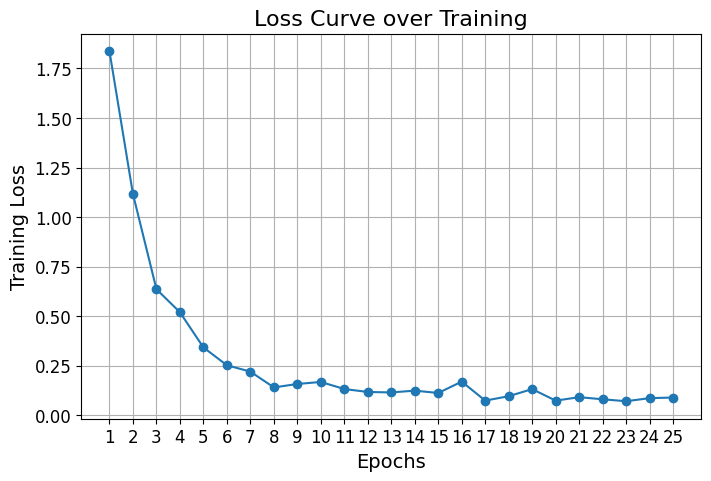

In [43]:
# Plotting the results
vector_vals = vector_vals = np.array(all_loss_results)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(vector_vals)+1), vector_vals, marker='o', linestyle='-')
plt.title("Loss Curve over Training", fontsize=16)
plt.xlabel("Epochs", fontsize=14)
plt.xticks(range(1, len(vector_vals) + 1))
plt.ylabel("Training Loss", fontsize=14)
plt.grid(True)
plt.tick_params(axis='x', labelsize=12)
plt.tick_params(axis='y', labelsize=12)
plt.show()


# 9. EVALUATE PERFORMANCE OVER ONLY TRAINING SAMPLES BEFORE AND AFTER FT

In [44]:

example_myBaseOPT_CD.eval()

model_pred = torch.zeros(0, dtype=torch.long).to(device)
ground_truth = torch.zeros(0, dtype=torch.long).to(device)

with torch.no_grad():
    for i, batch in enumerate(dataloader_CD_probs_exp_CDTRAIN):

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        gen_tokens = torch.tensor(1)
        gen_tokens = gen_tokens.to(device)


        # output only the binary yes/no,
        _, binary_yes_no, _ = example_myBaseOPT_CD.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
        model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
        ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
print("Average Train Exp Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  7 NUM EXPTS TOTAL:  8
BATCH#:  8 NUM EXPTS TOTAL:  9
BATCH#:  9 NUM EXPTS TOTAL:  10
BATCH#:  10 NUM EXPTS TOTAL:  11
BATCH#:  11 NUM EXPTS TOTAL:  12
BATCH#:  12 NUM EXPTS TOTAL:  13
BATCH#:  13 NUM EXPTS TOTAL:  14
BATCH#:  14 NUM EXPTS TOTAL:  15
BATCH#:  15 NUM EXPTS TOTAL:  16
Average Train Exp Accuracy:  37.5


In [45]:
# Set eval model for inference
# initialize to store results of model predictions and compare with ground-truth
# use generate text with only one token
# extract only the max score token YES (0 label) or NO (1 label)

example_myOPT_CD_FT.eval()

model_pred = torch.zeros(0, dtype=torch.long).to(device)
ground_truth = torch.zeros(0, dtype=torch.long).to(device)

with torch.no_grad():
    for i, batch in enumerate(dataloader_CD_probs_exp_CDTRAIN):

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        gen_tokens = torch.tensor(1)
        gen_tokens = gen_tokens.to(device)


        # output only the binary yes/no,
        _, binary_yes_no, _ = example_myOPT_CD_FT.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
        model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
        ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
print("Average Train Exp Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  7 NUM EXPTS TOTAL:  8
BATCH#:  8 NUM EXPTS TOTAL:  9
BATCH#:  9 NUM EXPTS TOTAL:  10
BATCH#:  10 NUM EXPTS TOTAL:  11
BATCH#:  11 NUM EXPTS TOTAL:  12
BATCH#:  12 NUM EXPTS TOTAL:  13
BATCH#:  13 NUM EXPTS TOTAL:  14
BATCH#:  14 NUM EXPTS TOTAL:  15
BATCH#:  15 NUM EXPTS TOTAL:  16
Average Train Exp Accuracy:  43.75


# 10. IN-DOMAIN VALIDATION

## 10.1 VALIDATION ON ORIGINAL MODEL (NOT FINE-TUNED)

In [46]:

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place


def format_examples_validation_VAL(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset_VAL(val_dataset, num_expts=num_experiments):
    combined_dataset = []


    for irep in range(num_expts):
      for val_ex in val_dataset:


            combined_ex = {'text': '', 'label': val_ex['label'], 'exp': irep+1}


            combined_ex['text'] += val_ex['text']

            # Append the new combined example to the combined dataset
            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_VAL(batch):

    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.tensor(labels, dtype=torch.long)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)


    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels_tensor,
        'exps': exps_tensor
    }


class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [47]:

formatted_val_dataset = val_dataset.map(format_examples_validation_VAL)



combined_dataset_VAL = create_combined_dataset_VAL(
                                          val_dataset = formatted_val_dataset,
                                          num_expts=num_experiments
                                           )

custom_dataset_VAL = CustomDataset(combined_dataset_VAL)
print(custom_dataset_VAL)

custom_dataset_VAL_EXP = CustomDataset([item for item in custom_dataset_VAL if item[0]['exp'] == SEL_EXP_TRAIN_CD])

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_VAL = DataLoader(custom_dataset_VAL_EXP, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_VAL, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [48]:
for i, batch in enumerate(dataloader_VAL):
    if i<20:
      print("ORIGINAL: ", i,)
      print("TOKENIZE / DETOKENIZE: ", OPT_tokenizer.batch_decode(batch['input_ids']))
    else:
      break

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


ORIGINAL:  0
TOKENIZE / DETOKENIZE:  ["</s>{no it didn't} question: {Yes it did.} Yes or No? answer: Ġ"]
ORIGINAL:  1
TOKENIZE / DETOKENIZE:  ["</s>{Who? asked Tommy.} question: {Tommy didn't know, who.} Yes or No? answer: Ġ"]
ORIGINAL:  2
TOKENIZE / DETOKENIZE:  ['</s>{Paroseas cave, reef, and wreck diving around its shores, giving the diver a wide range of environments to explore.} question: {The diver has no variety in places to explore, they are monotonous. } Yes or No? answer: Ġ']
ORIGINAL:  3
TOKENIZE / DETOKENIZE:  ["</s>{um i've visited the Wyoming area i'm not sure exactly where Dances with Wolves was filmed} question: {I don't know even though I visited the area.} Yes or No? answer: Ġ"]
ORIGINAL:  4
TOKENIZE / DETOKENIZE:  ["</s>{i think Buffalo is an up an coming team they're going to they're showing some real promise for the next uh few years} question: {Buffalo is showing some real promise for the next few years, I think they are an up and coming team.} Yes or No? answer: 

In [49]:

if SEL_EXP_TRAIN_CD == 1:
  example_myBaseOPT_CD.eval()

  model_pred = torch.zeros(0, dtype=torch.long).to(device)
  ground_truth = torch.zeros(0, dtype=torch.long).to(device)

  with torch.no_grad():
      for i, batch in enumerate(dataloader_VAL):

          print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

          input_ids = batch['input_ids'].to(device)
          attention_mask = batch['attention_mask'].to(device)

          gen_tokens = torch.tensor(1)
          gen_tokens = gen_tokens.to(device)


          # output only the binary yes/no,
          _, binary_yes_no, _ = example_myBaseOPT_CD.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
          model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
          ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

          print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size, "PREDICTION: ", binary_yes_no, "TRUE LABELS: ", batch['labels'].detach())

  accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
  print("Average Train Exp Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  0 NUM EXPTS TOTAL:  1 PREDICTION:  tensor([1.], dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  1 NUM EXPTS TOTAL:  2 PREDICTION:  tensor([1.], dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  2 NUM EXPTS TOTAL:  3 PREDICTION:  tensor([1.], dtype=torch.float16) TRUE LABELS:  tensor([1])
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  3 NUM EXPTS TOTAL:  4 PREDICTION:  tensor([1.], dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  4 NUM EXPTS TOTAL:  5 PREDICTION:  tensor([0.], dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  5 NUM EXPTS TOTAL:  6 PREDICTION:  tensor([1.], dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  6 NUM EXPTS TOTAL:  7 PREDICTION:  tensor([1.], dtype=torch.float16) TRUE LABELS:  tensor([0])
BATCH#:  7 NUM EXPTS TOTAL:  8
BATCH#:  7 NUM EXPTS TOT

In [50]:
# Evaluate results beyond accuracy:
if SEL_EXP_TRAIN_CD == 1:
  print("YES answer (%): ", ((torch.sum(model_pred==0))/len(model_pred)).item()*100)
  print("NO  answer (%): ", ((torch.sum(model_pred==1))/len(model_pred)).item()*100)

YES answer (%):  5.37109375
NO  answer (%):  94.62890625


In [51]:
# Check base model output correctness (from OPT HF example)
prompt_example = ("A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the "
              "Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived "
              "there?")
prompt_example_tokenized = OPT_tokenizer(prompt_example )
example_myBaseOPT_CD.eval()
outputs_ex_sp, binary_ex_sp, scores_ex_sp = example_myBaseOPT_CD.generate_text(src_inputs = torch.unsqueeze(torch.tensor(prompt_example_tokenized['input_ids']),0).to(device),
                                    src_attn = torch.unsqueeze(torch.tensor(prompt_example_tokenized['attention_mask']),0).to(device),
                                    gen_tokens=torch.tensor(100).to(device))
OPT_tokenizer.batch_decode(outputs_ex_sp)

['</s>A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived there?\nStatue: I have lived here for about a year.\nHuman: What is your favorite place to eat?\nStatue: I love to eat at the New York City Subway.\nHuman: What is your favorite movie?\nStatue: I love to watch movies.\nHuman: What is your favorite book?\nStatue: I love to read books.\nHuman: What is your favorite movie?\nStatue: I love to watch movies.\nHuman: What']

## 10.2 VALIDATION ON FINE TUNED MODEL

In [52]:

example_myOPT_CD_FT.eval()

model_pred = torch.zeros(0, dtype=torch.long).to(device)
ground_truth = torch.zeros(0, dtype=torch.long).to(device)

with torch.no_grad():
    for i, batch in enumerate(dataloader_VAL):

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        gen_tokens = torch.tensor(1)
        gen_tokens = gen_tokens.to(device)


        # output only the binary yes/no,
        _, binary_yes_no, _ = example_myOPT_CD_FT.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
        model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
        ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size, "PREDICTION: ", binary_yes_no, "TRUE LABELS: ", batch['labels'].detach())

accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
print("Average Train Exp Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  0 NUM EXPTS TOTAL:  1 PREDICTION:  tensor([0.]) TRUE LABELS:  tensor([1])
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  1 NUM EXPTS TOTAL:  2 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([0])
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  2 NUM EXPTS TOTAL:  3 PREDICTION:  tensor([0.]) TRUE LABELS:  tensor([1])
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  3 NUM EXPTS TOTAL:  4 PREDICTION:  tensor([0.]) TRUE LABELS:  tensor([0])
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  4 NUM EXPTS TOTAL:  5 PREDICTION:  tensor([0.]) TRUE LABELS:  tensor([0])
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  5 NUM EXPTS TOTAL:  6 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([0])
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  6 NUM EXPTS TOTAL:  7 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([0])
BATCH#:  7 NUM EXPTS TOTAL:  8
BATCH#:  7 NUM EXPTS TOTAL:  8 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([0])
BATCH#:  8 NUM EXPTS TOTAL:  9
BATCH#:  8 NUM EXPTS TOTAL:  9 PREDICTION:  tensor([1.]) 

In [53]:
# Evaluate results beyond accuracy:

print("YES answer (%): ", ((torch.sum(model_pred==0))/len(model_pred)).item()*100)
print("NO  answer (%): ", ((torch.sum(model_pred==1))/len(model_pred)).item()*100)

YES answer (%):  44.140625
NO  answer (%):  55.859375


In [54]:

list_labels_train = []

for i, batch in enumerate(dataloader_CD_probs_exp_CDTRAIN):

    #print(batch['OPT_probs'][0])
    #print(batch['OPT_idxs'][0])
    if 9904 in list(batch['OPT_idxs'][0]):
      yes_prob = batch['OPT_probs'][0][(batch['OPT_idxs'][0]==9904).nonzero(as_tuple=True)].item()
    else:
      yes_prob = 0
    if 3084 in list(batch['OPT_idxs'][0]):
      no_prob = batch['OPT_probs'][0][(batch['OPT_idxs'][0]==3084).nonzero(as_tuple=True)].item()
    else:
      no_prob = 0

    if yes_prob!=0 and no_prob!=0:
      result_to_train = ((no_prob - yes_prob)>0)*1
    else:
      result_to_train = 0.5

    list_labels_train.append(result_to_train)
print(list_labels_train)

print("YES TRAIN answer (%): ", ((torch.sum(torch.tensor(list_labels_train)==0))/len(list_labels_train)).item()*100)
print("NO  TRAIN answer (%): ", ((torch.sum(torch.tensor(list_labels_train)==1))/len(list_labels_train)).item()*100)

[1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1]
YES TRAIN answer (%):  50.0
NO  TRAIN answer (%):  50.0


In [55]:
# Check base model output correctness (from OPT HF example)
prompt_example = ("A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the "
              "Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived "
              "there?")
prompt_example_tokenized = OPT_tokenizer(prompt_example )
example_myOPT_CD_FT.eval()
outputs_ex_sp, binary_ex_sp, scores_ex_sp = example_myOPT_CD_FT.generate_text(src_inputs = torch.unsqueeze(torch.tensor(prompt_example_tokenized['input_ids']),0).to(device),
                                    src_attn = torch.unsqueeze(torch.tensor(prompt_example_tokenized['attention_mask']),0).to(device),
                                    gen_tokens=torch.tensor(100).to(device))
OPT_tokenizer.batch_decode(outputs_ex_sp)

['</s>A chat between a curious human and the Statue of Liberty.\n\nHuman: What is your name?\nStatue: I am the Statue of Liberty.\nHuman: Where do you live?\nStatue: New York City.\nHuman: How long have you lived there?\nStatue: I have lived here for about a year.\nHuman: What is your favorite place to eat?\nStatue: I love to eat at the New York City Subway.\nHuman: What is your favorite movie?\nStatue: I love to watch movies.\nHuman: What is your favorite book?\nStatue: I love to read books.\nHuman: What is your favorite movie?\nStatue: I love to watch movies.\nHuman: What']

# 11. OOD VALIDATION

In [56]:
dataset_ood = load_dataset("hans")
dataset_ood

Generating train split:   0%|          | 0/30000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/30000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
        num_rows: 30000
    })
    validation: Dataset({
        features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
        num_rows: 30000
    })
})

In [57]:
dataset_ood_val = (dataset_ood['validation']).filter(lambda example: example["heuristic"] == 'lexical_overlap')

Filter:   0%|          | 0/30000 [00:00<?, ? examples/s]

In [58]:
# Perform the filters and splits from the original datasets


random_split_seed_ood = 42 # set above, equal to 42

examples_per_exp =  examples_per_exp # 16
num_experiments = num_experiments # 10
num_validations = num_validations # 16*64 #64*16 = 1024 #6692

np.random.seed(random_split_seed_ood)
indices_ood_val = np.random.choice(range(len(dataset_ood_val)), size=num_validations, replace=False)
print("indices_ood_val: ", indices_ood_val)

dataset_ood_val_sel = dataset_ood_val.select(indices_ood_val)
dataset_ood_val_sel

indices_ood_val:  [6252 4684 1731 ... 9410 1671  474]


Dataset({
    features: ['premise', 'hypothesis', 'label', 'parse_premise', 'parse_hypothesis', 'binary_parse_premise', 'binary_parse_hypothesis', 'heuristic', 'subcase', 'template'],
    num_rows: 1024
})

In [59]:
# format examples functions formats according to different types of formats for ICL both training and validation examples

# select format to use here:
format_train_val = format_train_val # set it at the top of notebook in a common place


def format_examples_validation_VALOOD(example_val, format_val = format_train_val):
    if format_val== 'minimal':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} {" + example_val['hypothesis'] + "}" + " ? Ġ"}
    elif format_val== 'gpt3':
      # "minimal" format
      return {'text': "{"  + example_val['premise'] + "} question: {" + example_val['hypothesis'] + "}" + " Yes or No? answer: Ġ"}

def create_combined_dataset_VALOOD(val_dataset, num_expts=num_experiments):
    combined_dataset = []


    for irep in range(num_expts):
      for val_ex in val_dataset:

            combined_ex = {'text': '', 'label': val_ex['label'], 'exp': irep+1}

            combined_ex['text'] += val_ex['text']

            combined_dataset.append([combined_ex])

    return combined_dataset


def dynamic_padding_collate_fn_VALOOD(batch):


    batch = [item for sublist in batch for item in sublist]

    texts = [item['text'] for item in batch]
    labels = [item['label'] for item in batch]
    exps = [item['exp'] for item in batch]

    # choose option
    tokenized_inputs = OPT_tokenizer(texts, padding="longest", truncation=True, return_tensors="pt")
    # tokenized_inputs = OPT_tokenizer(texts, padding="max_length", max_length = 2048, truncation=True, return_tensors="pt")

    labels_tensor = torch.tensor(labels, dtype=torch.long)
    exps_tensor = torch.tensor(exps, dtype=torch.long).to(device)

    return {
        'input_ids': tokenized_inputs['input_ids'],
        'attention_mask': tokenized_inputs['attention_mask'],
        'labels': labels_tensor,
        'exps': exps_tensor
    }


class CustomDataset(Dataset):
    def __init__(self, combined_dataset):
        self.dataset = combined_dataset

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        return self.dataset[idx]


In [60]:


formatted_val_dataset_ood = dataset_ood_val_sel.map(format_examples_validation_VALOOD)


combined_dataset_VALOOD = create_combined_dataset_VALOOD(
                                          val_dataset = formatted_val_dataset_ood,
                                          num_expts=num_experiments
                                           )

custom_dataset_VALOOD = CustomDataset(combined_dataset_VALOOD)
print(custom_dataset_VALOOD)

custom_dataset_VALOOD_EXP = CustomDataset([item for item in custom_dataset_VALOOD if item[0]['exp'] == SEL_EXP_TRAIN_CD])

# Last step, we create Dataloader passing the bx_size for inference (typically: 1, 4, 8, 16)
bx_size = bx_size # set it up at the beg of NB
dataloader_VALOOD = DataLoader(custom_dataset_VALOOD_EXP, batch_size=bx_size, collate_fn=dynamic_padding_collate_fn_VALOOD, shuffle=False) #shuffle=False for reproducibility

Map:   0%|          | 0/1024 [00:00<?, ? examples/s]

In [61]:


example_myOPT_CD_FT.eval()

model_pred = torch.zeros(0, dtype=torch.long).to(device)
ground_truth = torch.zeros(0, dtype=torch.long).to(device)

with torch.no_grad():
    for i, batch in enumerate(dataloader_VALOOD):

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size)

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)

        gen_tokens = torch.tensor(1)
        gen_tokens = gen_tokens.to(device)


        # output only the binary yes/no,
        _, binary_yes_no, _ = example_myOPT_CD_FT.generate_text(input_ids, attention_mask, gen_tokens=gen_tokens)
        model_pred = torch.cat((model_pred, binary_yes_no), dim=0)
        ground_truth = torch.cat((ground_truth, batch['labels'].to(device)), dim=0)

        print("BATCH#: ", i, "NUM EXPTS TOTAL: ", (i+1)*bx_size, "PREDICTION: ", binary_yes_no, "TRUE LABELS: ", batch['labels'].detach())

accuracy_calc = (100*torch.sum(model_pred == ground_truth)/(model_pred.shape[0])).item()
print("Average OOD Experiment Accuracy: ", accuracy_calc)

BATCH#:  0 NUM EXPTS TOTAL:  1
BATCH#:  0 NUM EXPTS TOTAL:  1 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([0])
BATCH#:  1 NUM EXPTS TOTAL:  2
BATCH#:  1 NUM EXPTS TOTAL:  2 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([1])
BATCH#:  2 NUM EXPTS TOTAL:  3
BATCH#:  2 NUM EXPTS TOTAL:  3 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([1])
BATCH#:  3 NUM EXPTS TOTAL:  4
BATCH#:  3 NUM EXPTS TOTAL:  4 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([1])
BATCH#:  4 NUM EXPTS TOTAL:  5
BATCH#:  4 NUM EXPTS TOTAL:  5 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([1])
BATCH#:  5 NUM EXPTS TOTAL:  6
BATCH#:  5 NUM EXPTS TOTAL:  6 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([0])
BATCH#:  6 NUM EXPTS TOTAL:  7
BATCH#:  6 NUM EXPTS TOTAL:  7 PREDICTION:  tensor([1.]) TRUE LABELS:  tensor([1])
BATCH#:  7 NUM EXPTS TOTAL:  8
BATCH#:  7 NUM EXPTS TOTAL:  8 PREDICTION:  tensor([0.]) TRUE LABELS:  tensor([0])
BATCH#:  8 NUM EXPTS TOTAL:  9
BATCH#:  8 NUM EXPTS TOTAL:  9 PREDICTION:  tensor([0.]) 